In [1]:
import sys
import os

# Añadir la raíz del proyecto al path (ajusta si es necesario)
ROOT_DIR = os.path.abspath("..")
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [2]:
# results_notebooks/Fake-News.ipynb

import utils.bootcampviztools as bt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import importlib

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from utils import Clases
importlib.reload(Clases) # Para importar la librería de nuevo y que coja los cambios en el código
from utils.Clases import PlotUtils, Texts

# Librerías comunes para los modelos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Librería para obtener las métricas de los modelos
from utils import model_evaluator
importlib.reload(model_evaluator) # Recarga del módulo
from utils.model_evaluator import ModelEvaluator

In [3]:
# Configuración estética de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Ruta al dataset
DATA_PATH = "../data_sample/WELFake_Dataset.csv"

# Carga del dataset
df = pd.read_csv(DATA_PATH)

# Vista general del dataframe
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
# Previsualizamos algunos ejemplos de títulos
df["title"].sample(10).tolist()

["Clinton urges renewed 'fight for values'",
 'Sanders, Republican governors eye comeback in New Hampshire primary',
 "Trump win, Democratic setbacks cloud Pelosi's future as leader",
 'OPEN-BORDER LIBERALS Put Entire Nation On High Alert: German Spy Chief Warns 1,000+ Radical Islamists Ready To Attack…Over 100 ISIS Members Among Refugees',
 'What’s With The Electoral College?',
 'Sports Writers: Colin Kaepernick Getting Blackballed by the NFL - Breitbart',
 'SPOT ON! MARK STEYN Delivers A Dire Warning To The Never Trump Folks',
 'Obamacare on the line at SCOTUS',
 'Tactical Augmented Reality Gives Soldiers a Video Game-Style HUD on the Battlefield - Breitbart',
 'Fear of ‘Catastrophe Unfolding’ Amid Fighting in Falluja - The New York Times']

In [5]:
# Previsualizamos algunos ejemplos de textos
df["text"].sample(10).tolist()

['Holder should be making his baseless remarks from behind bars but that s another story Retired Attorney General Eric Holder pushed back on statements made last week by FBI Director James Comey in which Comey suggested the so-called Ferguson effect might be responsible for a recent rise in crime in cities around the country.In a gathering with reporters Wednesday, Holder told the Huffington Post,  I don t agree with the comments that he s made about, or the connection he s drawn, between the so-called  Ferguson effect  and this rise in crime. The Ferguson effect is a name given to a recent spike in crime in some, but not all, American cities this year. The idea is that police have taken note of the public mood and decided to hold back on more aggressive policing.Eric Holder told the Huffington Post the factors involved in the crime surge would be difficult to tease out,  It s hard for us to understand why crime dropped to historic lows over the last 40 years. I think it s probably equ

#### Realizamos un análisis inicial (Comprobando nulos y obteniendo la distribución de clases por 'label')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB

Valores nulos por columna:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


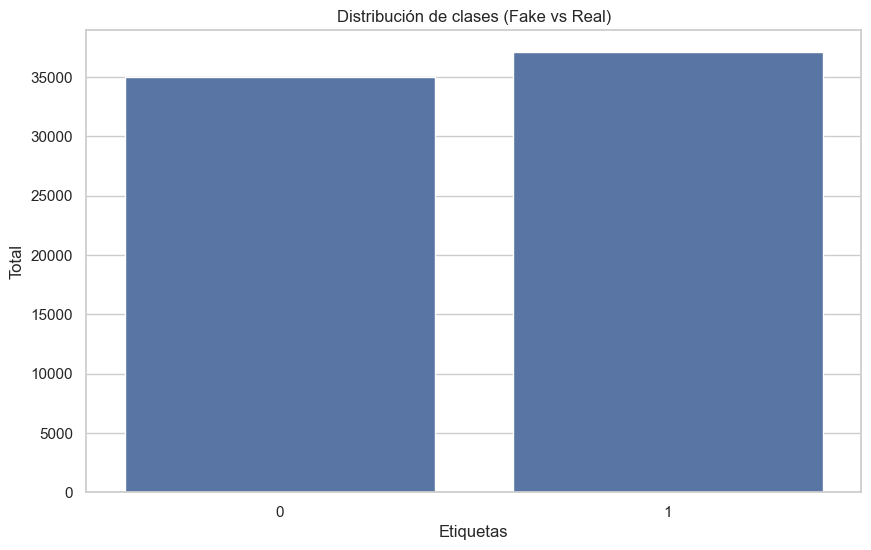

In [6]:
df.info()

# Contabilizamos valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Distribución de clases (columna 'label' o similar)
if 'label' in df.columns:
    sns.countplot(data=df, x='label')
    plt.title("Distribución de clases (Fake vs Real)")
    plt.xlabel("Etiquetas")
    plt.ylabel("Total")
    plt.show()
else:
    print("No se encuentra la columna 'label' en el dataset.")


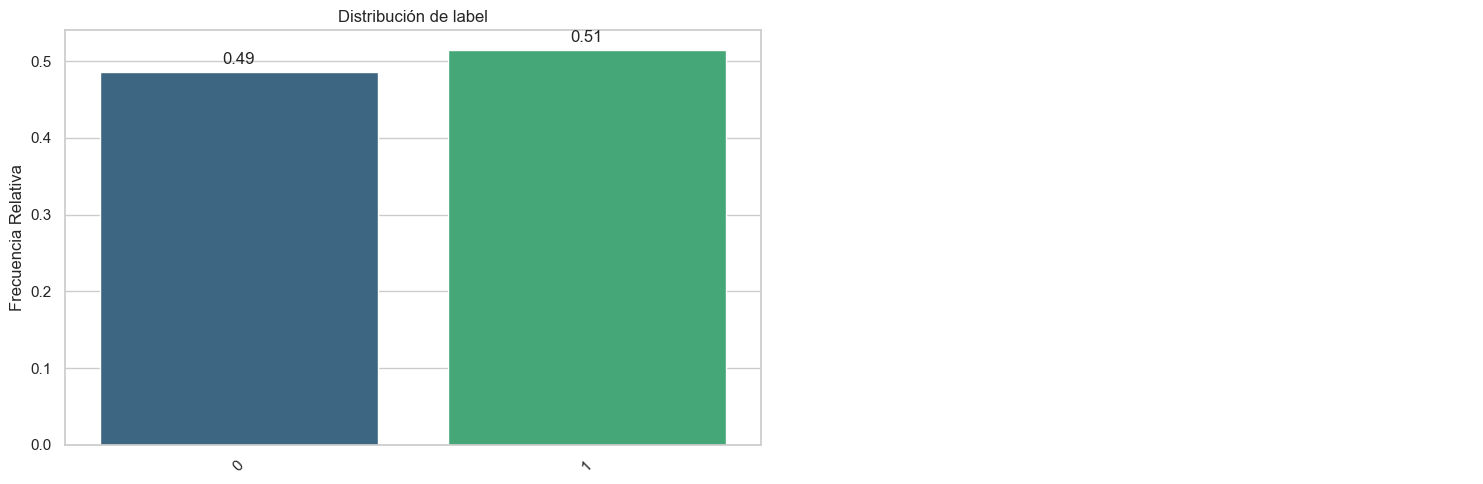

In [7]:
# Obtenemos la distribución en porcentaje de las etiquetas (Frecuencias relativas)
target = "label"
bt.pinta_distribucion_categoricas(
    df,
    [target],
    True,
    True
)

#### Comprobamos que las 'label' del dataset se encuentra bastante balanceado

In [8]:
# Rellenamos los títulos nulos con cadena vacía (Tenemos 558 títulos nulos)
df.fillna({"title": ""}, inplace=True)

In [9]:
# Eliminar filas con texto nulo (Sólo existen 39 textos nulos)
df = df[df["text"].notnull()]

In [10]:
# Eliminar columna innecesaria
df.drop(columns=["Unnamed: 0"], inplace=True)

In [11]:
# 1. Vamos a realizar un análisis de la longitud de los textos:

# 1.1 Calcular el número de palabras por texto.

df["text_word_count"] = df["text"].apply(lambda x: len(str(x).split()))
print("Estadísticas de longitud (palabras):")
print(df["text_word_count"].describe())


Estadísticas de longitud (palabras):
count    72095.000000
mean       540.843346
std        625.442464
min          0.000000
25%        227.000000
50%        399.000000
75%        667.000000
max      24234.000000
Name: text_word_count, dtype: float64


In [12]:
# 1.2 Calcular la longitud en caracteres.

df["text_char_count"] = df["text"].apply(lambda x: len(str(x)))
print("\nEstadísticas de longitud (caracteres):")
print(df["text_char_count"].describe())


Estadísticas de longitud (caracteres):
count     72095.000000
mean       3270.155878
std        3733.112756
min           1.000000
25%        1379.000000
50%        2425.000000
75%        4060.000000
max      142961.000000
Name: text_char_count, dtype: float64


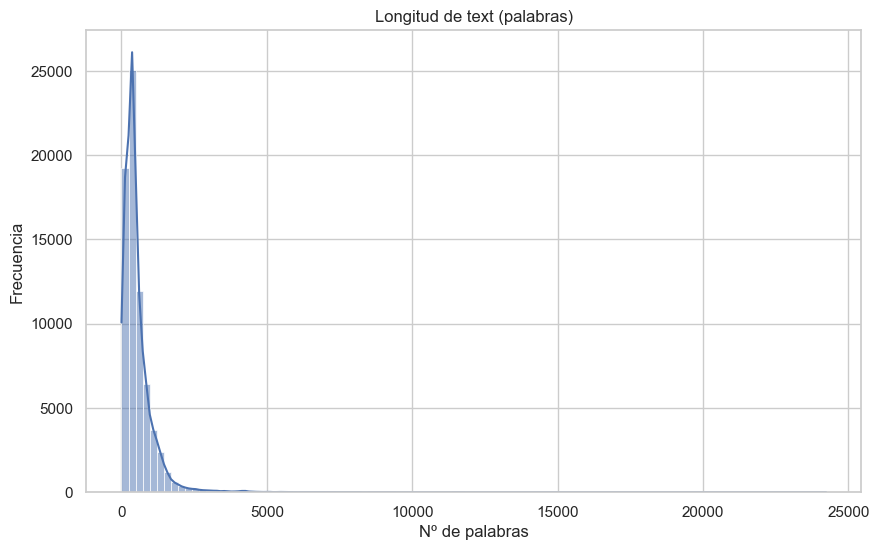

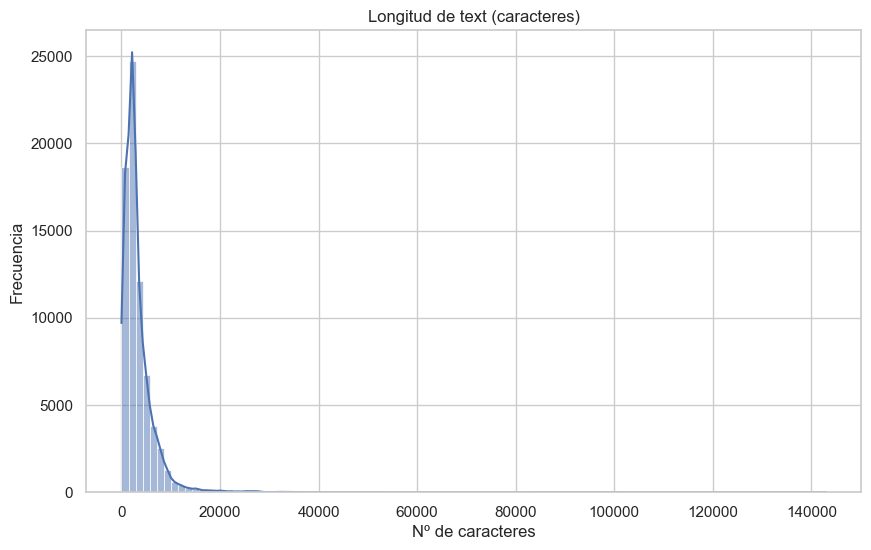

In [13]:
# 1.3 Visualizar estas distribuciones.

# Instanciamos la clase
plotter = PlotUtils(output_dir="../img")

# Generamos y guardamos gráficas para el texto
plotter.plot_text_length_distributions(df, text_col="text", prefix="text", show=True)


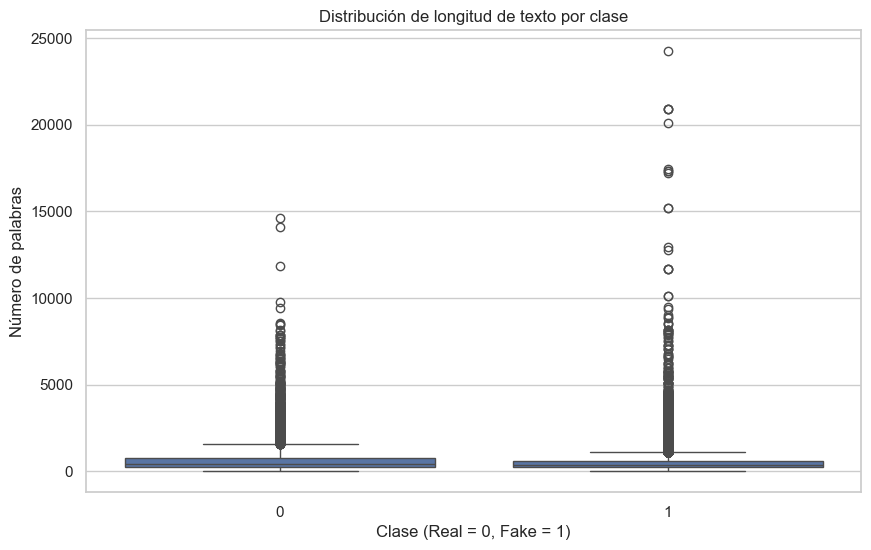

In [14]:
# 1.4 Comparar longitudes entre clases (real vs fake).

# Instanciamos la clase
plotter = PlotUtils(output_dir="../img")

# Boxplot por clase (Fake vs Real)
plotter.plot_boxplot_by_class(
    df=df,
    x_col="label",
    y_col="text_word_count",
    title="Distribución de longitud de texto por clase",
    xlabel="Clase (Real = 0, Fake = 1)",
    ylabel="Número de palabras",
    filename="boxplot_text_wordcount_by_label.png",
    show=True
)


#### Vamos a realizar el mismo procesamiento a los títulos, igual que a los textos

In [15]:
# Verificamos que existen caracteres extraños en los títulos
df["title"].apply(lambda x: re.findall(r"\W+", str(x))).sample(10)


29160       [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , -,  ,  (, )]
17237              [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ]
68943    [ ,  ,  ,  ,  ,  ,  ,  , : “,  ,  , *, ”…,  “,...
12953    [: ’,  , ’,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ’,  ...
50658                                [ ,  ,  ,  ,  ,  ,  ]
31903    [ , ? ,  ,  ,  ,  ,  ,  , , ,  ,  ,  ,  ,  ,  ...
50416                            [ ,  ,  ,  ,  ,  , ., . ]
3688                           [ ,  ,  ,  ,  ,  ,  ,  ,  ]
22242                                   [ ,  ,  ,  ,  ,  ]
41574                 [ ',  , ' ,  ,  ,  ,  ,  ,  , , ,  ]
Name: title, dtype: object

In [16]:
# Aplicamos limpieza sobre la columna 'title'
df["title_clean"] = df["title"].apply(Texts.clean_text_basic)

In [17]:
# 1. Vamos a realizar un análisis de la longitud de los títulos:

# 1.1 Calcular el número de palabras por título (sobre el texto limpio).

df["title_word_count"] = df["title_clean"].apply(lambda x: len(x.split()))
print("Estadísticas de título (palabras):")
print(df["title_word_count"].describe())


Estadísticas de título (palabras):
count    72095.000000
mean        12.592260
std          4.500565
min          0.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         69.000000
Name: title_word_count, dtype: float64


In [18]:
# 1.2 Calcular la longitud en caracteres.

df["title_char_count"] = df["title"].apply(lambda x: len(str(x)))
print("\nEstadísticas de título (caracteres):")
print(df["title_char_count"].describe())



Estadísticas de título (caracteres):
count    72095.000000
mean        76.533269
std         25.831377
min          0.000000
25%         61.000000
50%         73.000000
75%         89.000000
max        456.000000
Name: title_char_count, dtype: float64


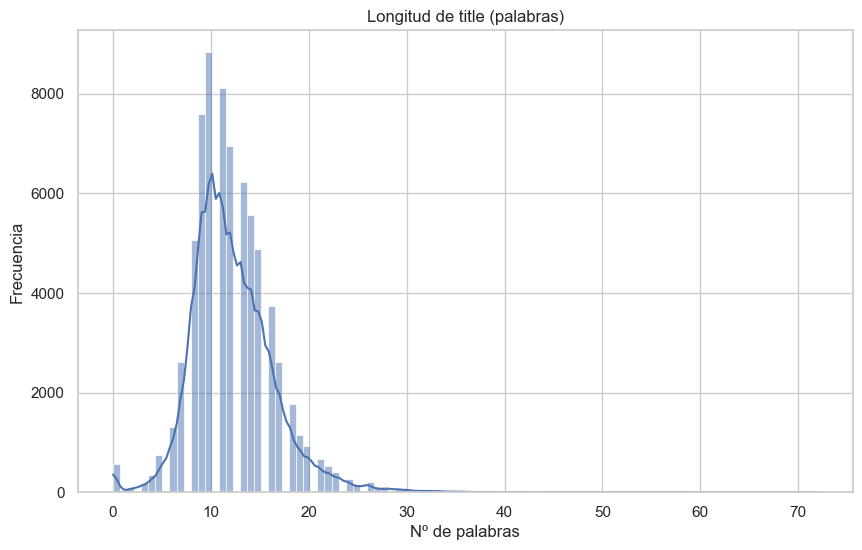

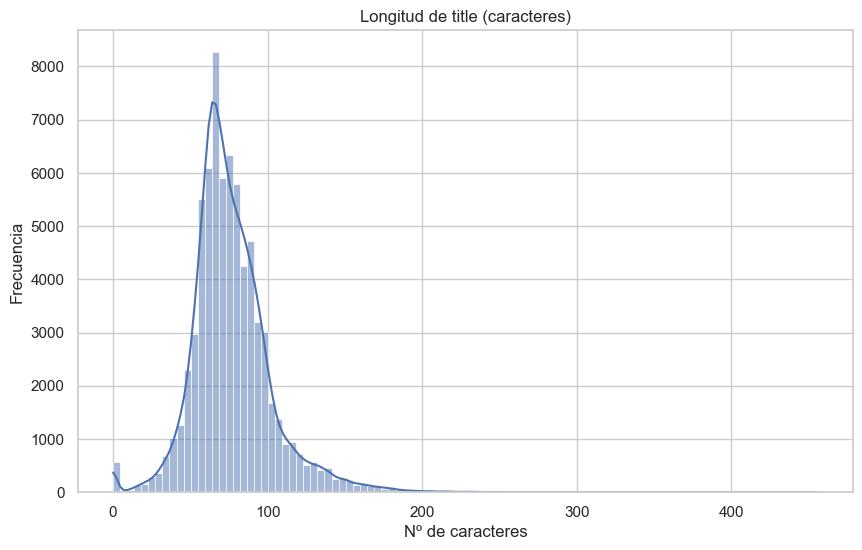

In [19]:
# Generamos y guardamos gráficas para los títulos
plotter.plot_text_length_distributions(df, text_col="title", prefix="title", show=True)

In [20]:
# Tokenizar sobre los textos limpios
df["title_tokens"] = df["title_clean"].apply(Texts.tokenize)

# Eliminar stopwords
df["title_tokens_nostop"] = df["title_tokens"].apply(lambda tokens: Texts.remove_stopwords(tokens, language="english"))

# Verificamos el resultado
df[["title", "title_clean", "title_tokens", "title_tokens_nostop"]].head()


,title,title_clean,title_tokens,title_tokens_nostop
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement on high alert following threat...,"[law, enforcement, on, high, alert, following,...","[law, enforcement, high, alert, following, thr..."
1,,,[],[]
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obama s attorney general says mos...,"[unbelievable, obama, s, attorney, general, sa...","[unbelievable, obama, attorney, general, says,..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu uses story of christ...,"[bobby, jindal, raised, hindu, uses, story, of...","[bobby, jindal, raised, hindu, uses, story, ch..."
4,SATAN 2: Russia unvelis an image of its terrif...,satan 2 russia unvelis an image of its terrify...,"[satan, 2, russia, unvelis, an, image, of, its...","[satan, 2, russia, unvelis, image, terrifying,..."


#### Resumen de longitud de títulos y textos

* Media de palabras en títulos: 12
* Media de palabras en textos: 540

##### Vamos a realizar la lematización para reducir los textos aún más y ayudar a reducir el vocabulario sin perder significado.

In [21]:
# Texto original limpio
df["text_clean"] = df["text"].apply(Texts.clean_text_basic)

# Recortar texto limpio antes de lematizar (Sólo clasificamos los primeros 150 tokens que suelen contener lo esencial para mayor velocidad)
df["text_cut"] = df["text_clean"].apply(lambda x: " ".join(x.split()[:150]))

In [22]:
# Lematización sobre los textos limpios
df["text_lemma"] = Texts.lemmatize_bulk_blocked(
    texts=df["text_cut"],
    to_lower=True,
    remove_stop=True,
    batch_size=50,
    block_size=5000,
    output_dir="../models",
    final_output_path="../models/text_lemma_final.pkl"
)

# Ver ejemplo
df[["text", "text_clean", "text_lemma"]].head(3)


Retomando desde el bloque 0 de 15


Lematizando (por bloques):   7%|▋         | 1/15 [01:53<26:30, 113.63s/it]

Bloque 0 guardado: ../models\text_lemma_block_0.pkl


Lematizando (por bloques):  13%|█▎        | 2/15 [03:34<22:57, 106.00s/it]

Bloque 1 guardado: ../models\text_lemma_block_1.pkl


Lematizando (por bloques):  20%|██        | 3/15 [05:12<20:28, 102.37s/it]

Bloque 2 guardado: ../models\text_lemma_block_2.pkl


Lematizando (por bloques):  27%|██▋       | 4/15 [06:55<18:50, 102.78s/it]

Bloque 3 guardado: ../models\text_lemma_block_3.pkl


Lematizando (por bloques):  33%|███▎      | 5/15 [08:46<17:34, 105.49s/it]

Bloque 4 guardado: ../models\text_lemma_block_4.pkl


Lematizando (por bloques):  40%|████      | 6/15 [10:27<15:36, 104.10s/it]

Bloque 5 guardado: ../models\text_lemma_block_5.pkl


Lematizando (por bloques):  47%|████▋     | 7/15 [12:12<13:55, 104.49s/it]

Bloque 6 guardado: ../models\text_lemma_block_6.pkl


Lematizando (por bloques):  53%|█████▎    | 8/15 [13:52<12:00, 102.87s/it]

Bloque 7 guardado: ../models\text_lemma_block_7.pkl


Lematizando (por bloques):  60%|██████    | 9/15 [15:46<10:38, 106.45s/it]

Bloque 8 guardado: ../models\text_lemma_block_8.pkl


Lematizando (por bloques):  67%|██████▋   | 10/15 [17:29<08:47, 105.55s/it]

Bloque 9 guardado: ../models\text_lemma_block_9.pkl


Lematizando (por bloques):  73%|███████▎  | 11/15 [19:15<07:01, 105.40s/it]

Bloque 10 guardado: ../models\text_lemma_block_10.pkl


Lematizando (por bloques):  80%|████████  | 12/15 [21:07<05:22, 107.42s/it]

Bloque 11 guardado: ../models\text_lemma_block_11.pkl


Lematizando (por bloques):  87%|████████▋ | 13/15 [23:10<03:44, 112.23s/it]

Bloque 12 guardado: ../models\text_lemma_block_12.pkl


Lematizando (por bloques):  93%|█████████▎| 14/15 [24:57<01:50, 110.70s/it]

Bloque 13 guardado: ../models\text_lemma_block_13.pkl


Lematizando (por bloques): 100%|██████████| 15/15 [25:46<00:00, 103.13s/it]

Bloque 14 guardado: ../models\text_lemma_block_14.pkl

Uniendo bloques...


Archivo final guardado en: ../models/text_lemma_final.pkl


,text,text_clean,text_lemma
0,No comment is expected from Barack Obama Membe...,no comment is expected from barack obama membe...,comment expect barack obama member fyf911 fuky...
1,Did they post their votes for Hillary already?,did they post their votes for hillary already,post vote hillary
2,"Now, most of the demonstrators gathered last ...",now most of the demonstrators gathered last ni...,demonstrator gather night exercise constitutio...


### Comencemos con los modelados en DL
--------------------------------------

In [23]:
# Usamos la columna lematizada (puedes usar otra si quieres comparar)
X = df["text_lemma"]
y = df["label"]

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorización de textos con TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)


In [24]:
# Instanciamos la Clase ModelEvaluator donde guardaremos las métricas para comparar al final todos los modelos
evaluator = ModelEvaluator()

Logistic Regression
==============================

In [25]:
from sklearn.linear_model import LogisticRegression

# Entrenamiento del modelo de regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Resultados del modelo:
Accuracy: 0.9097024758998543
Precision: 0.8940038684719536
Recall: 0.9352488870902469
F1-score: 0.9141613924050633


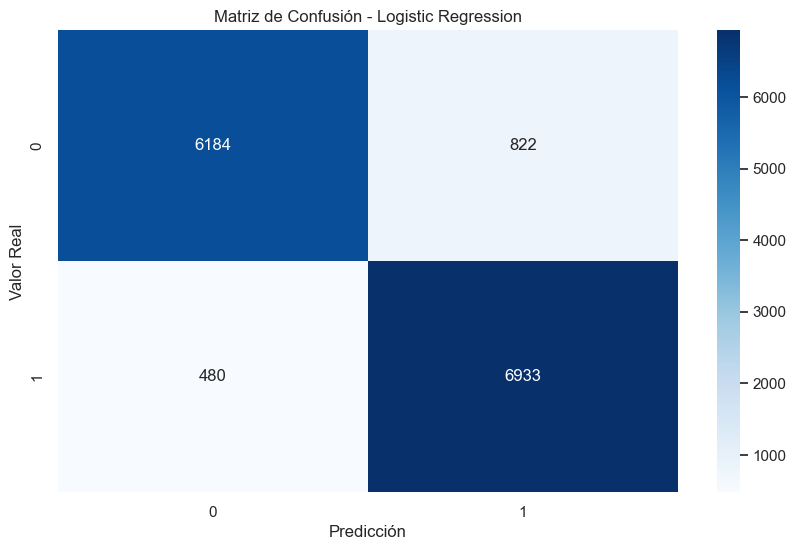


Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.88      0.90      7006
        Fake       0.89      0.94      0.91      7413

    accuracy                           0.91     14419
   macro avg       0.91      0.91      0.91     14419
weighted avg       0.91      0.91      0.91     14419

Reporte visual guardado en: ../img\classification_report_logistic_regression.png


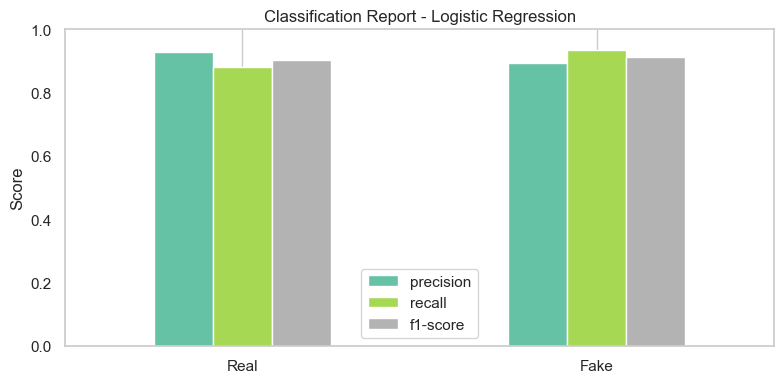

In [26]:
y_pred_lr = model.predict(X_test)

print("Resultados del modelo:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

# Matriz de confusión
evaluator.plot_confusion_matrix(y_test, y_pred_lr, model_name="Logistic Regression")

evaluator.print_classification_report(y_test, y_pred_lr)

# Classification report (visual)
evaluator.plot_classification_report(y_test, y_pred_lr, model_name="Logistic Regression", save=True)

| Métrica    | Valor     | Explicación                                                                    |
|------------|-----------|--------------------------------------------------------------------------------|
| Accuracy   | 90.97 %   | El modelo acierta en el 91% de los casos totales (reales + falsas).            |
| Precision  | 89.40 %   | De todas las noticias clasificadas como Fake, el 89.4% realmente lo eran.      |
| Recall     | 93.52 %   | El modelo detecta correctamente el 93.5% de las Fake News reales.              |
| F1-score   | 91.42 %   | Es un balance entre precision y recall.                                        |


- El modelo detecta mejor las Fake News que las reales.
- Tiende a confundir algunas noticias reales como falsas (falsos positivos).
- Buen balance general en ambas clases → modelo robusto y generalizable.


SVM (Support Vector Machine)
==============================

In [27]:
# Usaremos LinearSVC porque funciona mejor y es más rápido con TF-IDF en problemas de texto de alta dimensión.
from sklearn.svm import LinearSVC

In [28]:
# Entrenamiento del modelo SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

In [29]:
y_pred_svm = svm_model.predict(X_test)

print("Resultados del modelo SVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))

Resultados del modelo SVM:
Accuracy: 0.912962063943408
Precision: 0.8999740192257729
Recall: 0.9345743963307702
F1-score: 0.9169479187346966


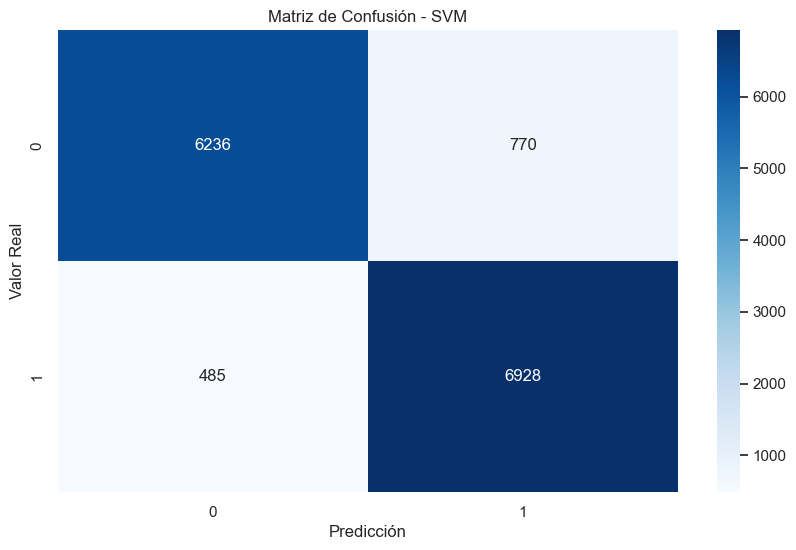


Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.89      0.91      7006
        Fake       0.90      0.93      0.92      7413

    accuracy                           0.91     14419
   macro avg       0.91      0.91      0.91     14419
weighted avg       0.91      0.91      0.91     14419

Reporte visual guardado en: ../img\classification_report_svm.png


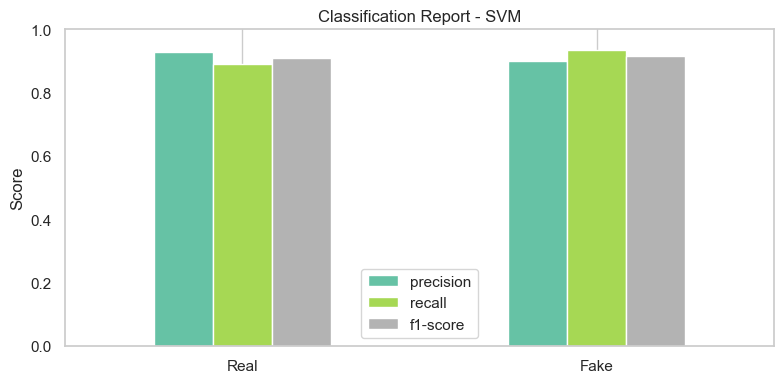

In [30]:
# Matriz de confusión
evaluator.plot_confusion_matrix(y_test, y_pred_svm, model_name="SVM")

evaluator.print_classification_report(y_test, y_pred_svm)

# Classification report (visual)
evaluator.plot_classification_report(y_test, y_pred_svm, model_name="SVM", save=True)

Random Forest
==============================

In [31]:
from sklearn.ensemble import RandomForestClassifier

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Entrenamiento
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train_dense, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [32]:
y_pred_rf = rf_model.predict(X_test)

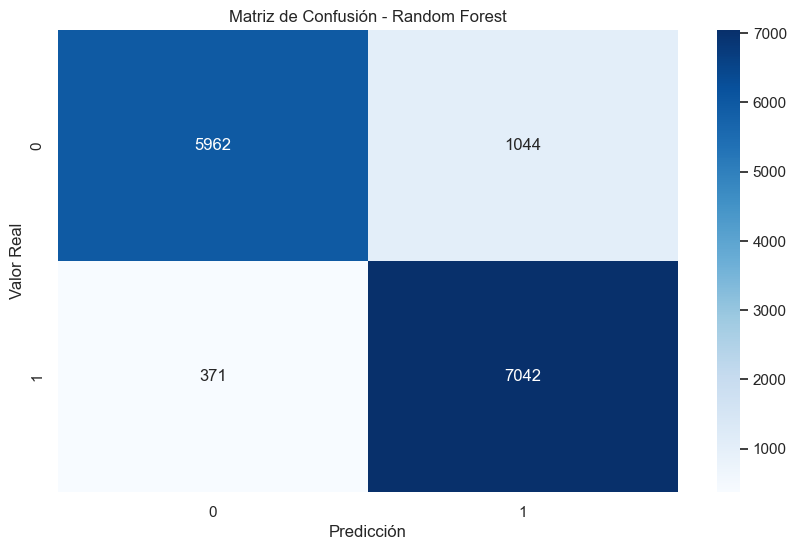


Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.85      0.89      7006
        Fake       0.87      0.95      0.91      7413

    accuracy                           0.90     14419
   macro avg       0.91      0.90      0.90     14419
weighted avg       0.91      0.90      0.90     14419

Reporte visual guardado en: ../img\classification_report_random_forest.png


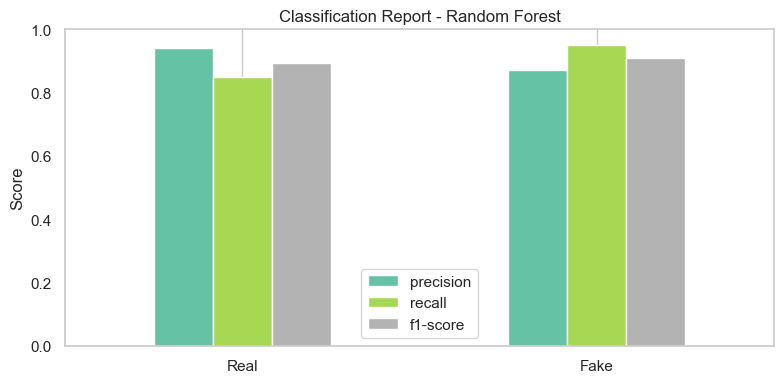

In [33]:
# Añadir métricas
evaluator.add_metrics("Random Forest", y_test, y_pred_rf)

# Matriz de confusión
evaluator.plot_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")

evaluator.print_classification_report(y_test, y_pred_rf)

# Classification report (visual)
evaluator.plot_classification_report(y_test, y_pred_rf, model_name="Random Forest", save=True)

XGBoost
=======

In [34]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
y_pred_xgb = xgb_model.predict(X_test)

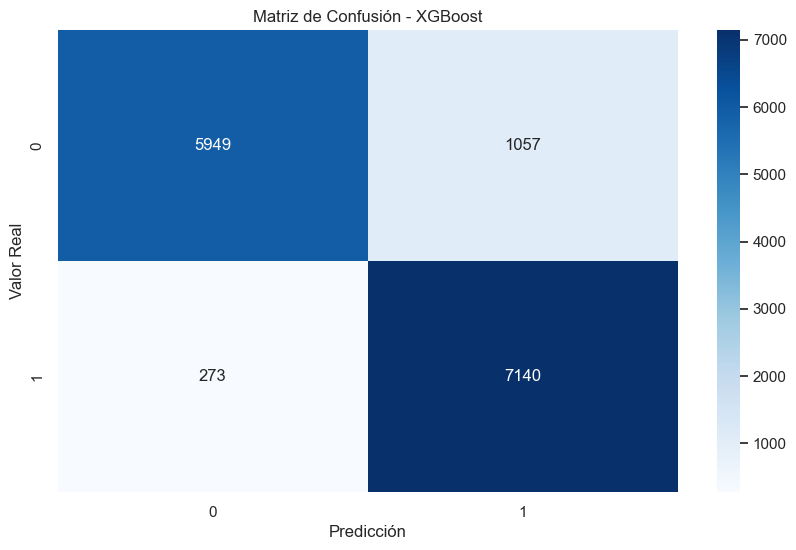


Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.85      0.90      7006
        Fake       0.87      0.96      0.91      7413

    accuracy                           0.91     14419
   macro avg       0.91      0.91      0.91     14419
weighted avg       0.91      0.91      0.91     14419

Reporte visual guardado en: ../img\classification_report_xgboost.png


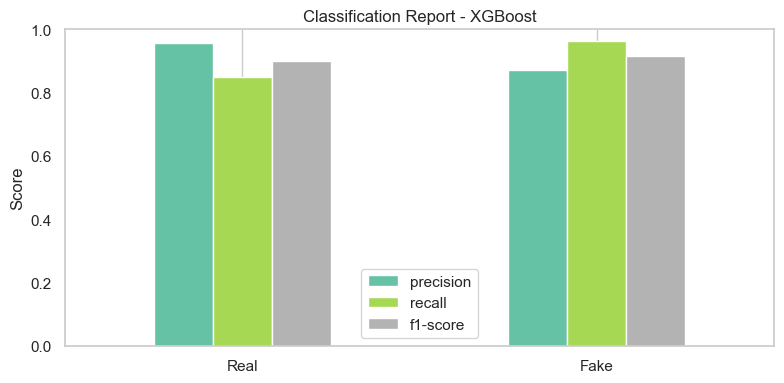

In [36]:
# Añadir métricas al evaluador
evaluator.add_metrics("XGBoost", y_test, y_pred_xgb)

# Matriz de confusión
evaluator.plot_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost")

evaluator.print_classification_report(y_test, y_pred_xgb)

# Reporte visual
evaluator.plot_classification_report(y_test, y_pred_xgb, model_name="XGBoost", save=True)

LightGBM
========

In [37]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True  # Force column-wise multi-threading
)

# Entrenamos directamente sobre sparse matrix
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Info] Number of positive: 29654, number of negative: 28022
[LightGBM] [Info] Total Bins 561043
[LightGBM] [Info] Number of data points in the train set: 57676, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514148 -> initscore=0.056607
[LightGBM] [Info] Start training from score 0.056607


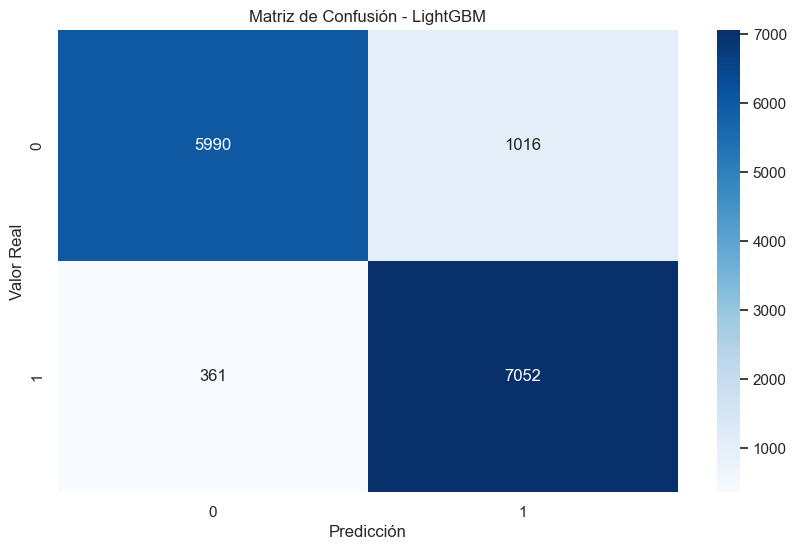

Reporte visual guardado en: ../img\classification_report_lightgbm.png


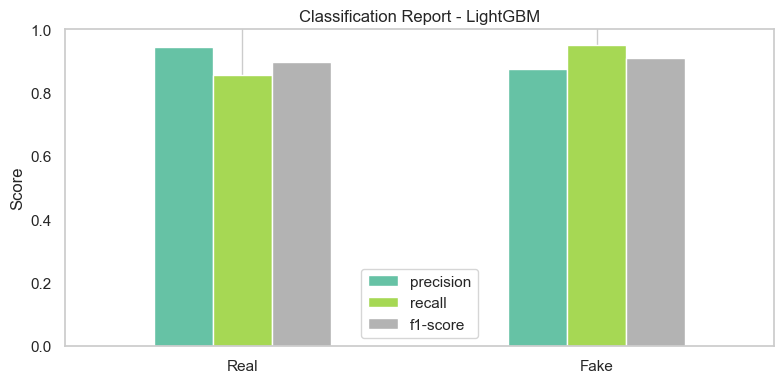

In [38]:
# Añadir al evaluador
evaluator.add_metrics("LightGBM", y_test, y_pred_lgbm)

# Matriz de confusión
evaluator.plot_confusion_matrix(y_test, y_pred_lgbm, model_name="LightGBM")

# Classification report (visual)
evaluator.plot_classification_report(y_test, y_pred_lgbm, model_name="LightGBM", save=True)

Red Neuronal Multicapa (MLP)
============================

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
X_train_dense = X_train.toarray().astype('float32')
X_test_dense = X_test.toarray().astype('float32')

# Escalado de los datos (0-1)
X_train_norm = X_train_dense / 255.0
X_test_norm = X_test_dense / 255.0

In [41]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_norm.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Clasificación binaria
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_norm, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_norm, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5320 - loss: 0.6843 - val_accuracy: 0.8442 - val_loss: 0.4354
Epoch 2/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8316 - loss: 0.4090 - val_accuracy: 0.8668 - val_loss: 0.3162
Epoch 3/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8657 - loss: 0.3286 - val_accuracy: 0.8870 - val_loss: 0.2711
Epoch 4/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8885 - loss: 0.2841 - val_accuracy: 0.8960 - val_loss: 0.2543
Epoch 5/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9007 - loss: 0.2589 - val_accuracy: 0.9002 - val_loss: 0.2430
Epoch 6/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9037 - loss: 0.2471 - val_accuracy: 0.9061 - val_loss: 0.2337
Epoch 7/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9141 - loss: 0.2286 - val_accuracy: 0.9076 - val_loss: 0.2278
Epoch 8/50
1803/1803 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9137 - loss

451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


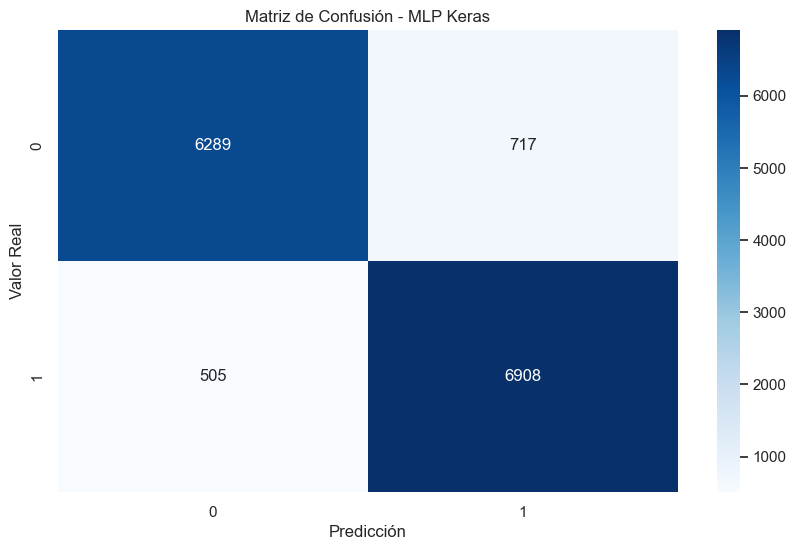

Reporte visual guardado en: ../img\classification_report_mlp_keras.png


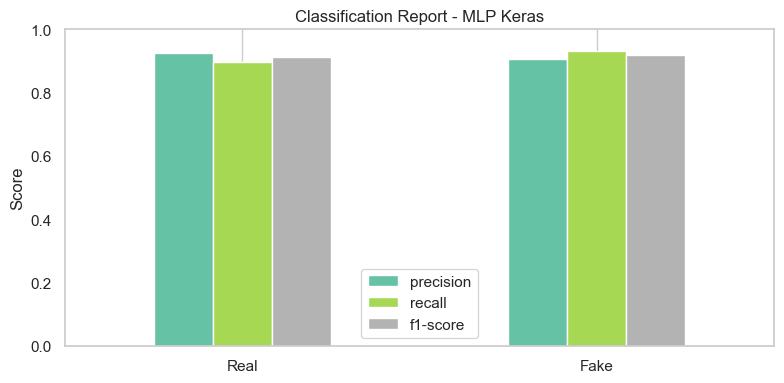

In [43]:
y_pred_proba = model.predict(X_test_norm)
y_pred_keras = (y_pred_proba > 0.5).astype(int).flatten()

# Añadir al evaluador
evaluator.add_metrics("MLP Keras", y_test, y_pred_keras)
evaluator.plot_confusion_matrix(y_test, y_pred_keras, model_name="MLP Keras")
evaluator.plot_classification_report(y_test, y_pred_keras, model_name="MLP Keras", save=True)

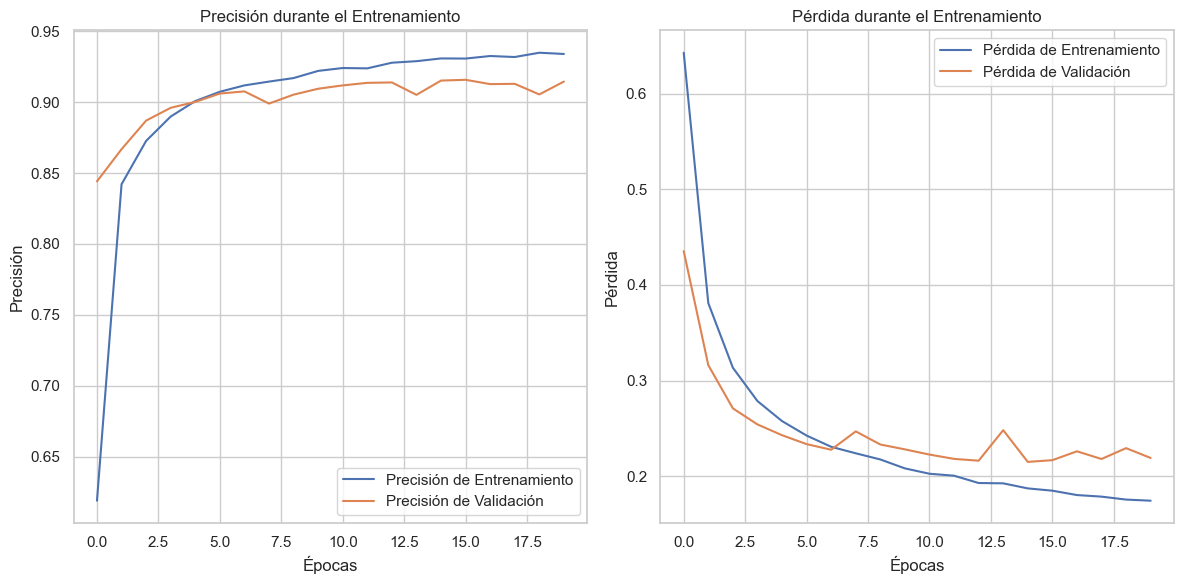

In [44]:
# Mostrar el historial de entrenamiento
plt.figure(figsize=(12, 6))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

Resumen de la evaluación de todos los modelos
=============================================

Confusion matrices guardadas en: ../img\confusion_matrices.png


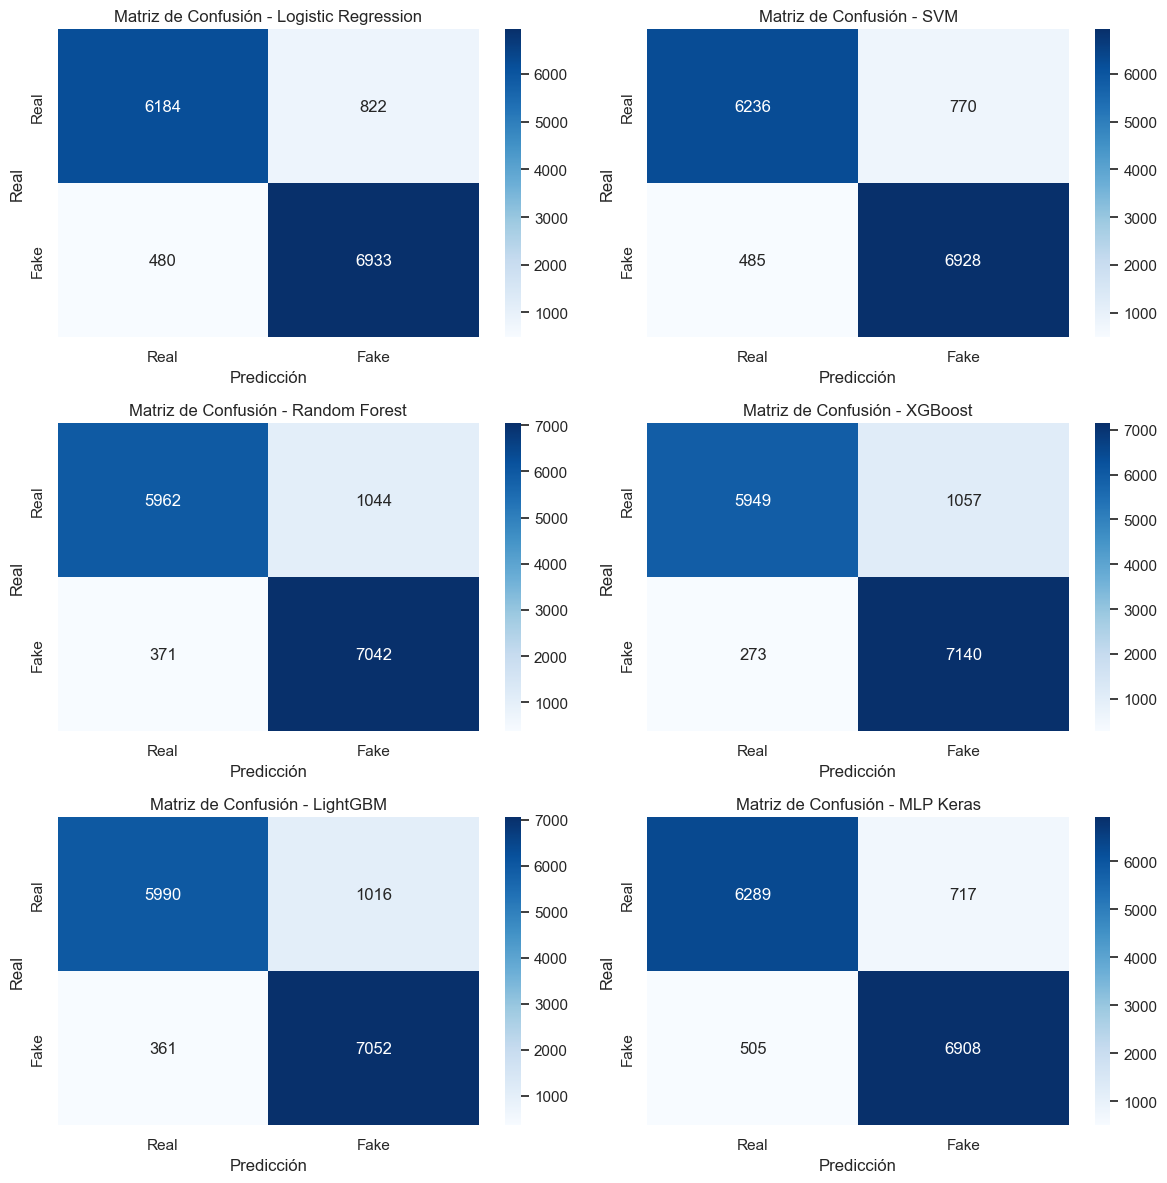

Classification reports guardados en: ../img\classification_reports.png


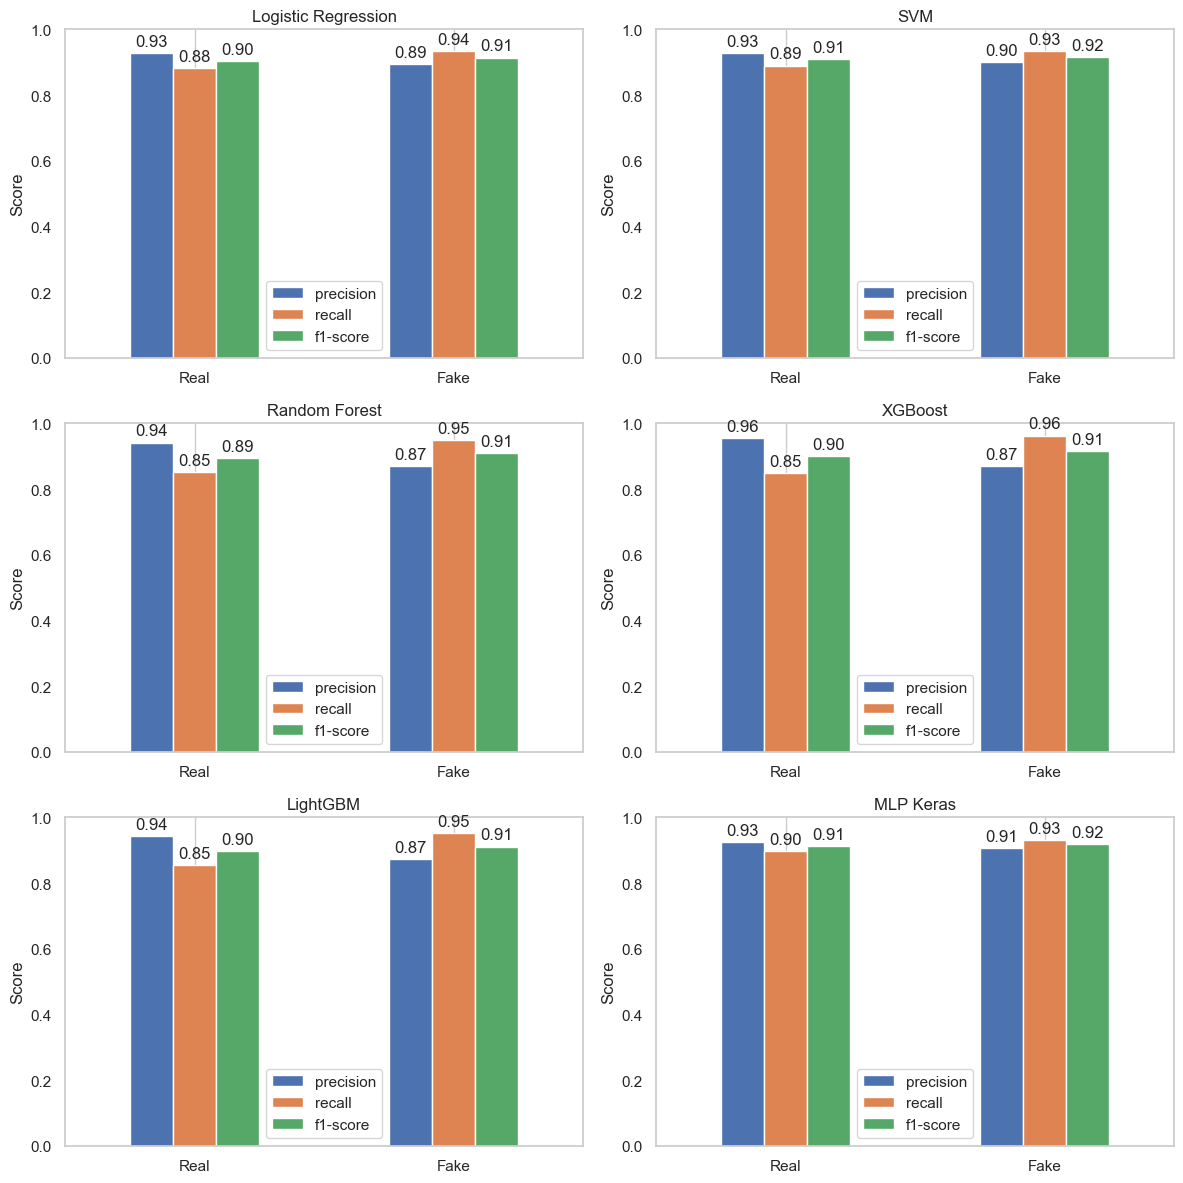

In [45]:
evaluator.add_metrics("Logistic Regression", y_test, y_pred_lr)
evaluator.add_metrics("SVM", y_test, y_pred_svm)
evaluator.add_metrics("Random Forest", y_test, y_pred_rf)
evaluator.add_metrics("XGBoost", y_test, y_pred_xgb)
evaluator.add_metrics("LightGBM", y_test, y_pred_lgbm)
evaluator.add_metrics("MLP Keras", y_test, y_pred_keras)

# Si ya tenemos las predicciones de cada modelo
y_preds = [y_pred_lr, y_pred_svm, y_pred_rf, y_pred_xgb, y_pred_lgbm, y_pred_keras]
model_names = ["Logistic Regression", "SVM", "Random Forest", "XGBoost", "LightGBM", "MLP Keras"]

evaluator.plot_all_confusion_matrices(
    y_true_list=[y_test] * len(y_preds),
    y_pred_list=y_preds,
    model_names=model_names,
    save=True
)

evaluator.plot_classification_reports(
    y_true_list=[y_test] * len(y_preds),
    y_pred_list=y_preds,
    model_names=model_names,
    save=True
)


In [46]:
# Ver y guardar métricas
df_metrics = evaluator.get_metrics_df()
evaluator.save_metrics()
df_metrics

Métricas guardadas en CSV: ../models\model_metrics_comparison.csv
Métricas guardadas en JSON: ../models\model_metrics_comparison.json


,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.901866,0.870888,0.949953,0.908704
1,XGBoost,0.907761,0.871050,0.963173,0.914798
2,LightGBM,0.904501,0.874070,0.951302,0.911052
3,MLP Keras,0.915251,0.905967,0.931876,0.918739
4,Logistic Regression,0.909702,0.894004,0.935249,0.914161
5,SVM,0.912962,0.899974,0.934574,0.916948
6,Random Forest,0.901866,0.870888,0.949953,0.908704
7,XGBoost,0.907761,0.871050,0.963173,0.914798
8,LightGBM,0.904501,0.874070,0.951302,0.911052
9,MLP Keras,0.915251,0.905967,0.931876,0.918739
